# Object-based filtering of pixel classifications <img align="right" src="../../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">




## Background

Geographic Object-Based Image Analysis (GEOBIA), which aims to group pixels together into meaningful image-objects. There are two advantages to a GEOBIA worklow; one, we can reduce the 'salt and pepper' effect typical of classifying pixels; and two, we can increase the computational efficiency of our workflow by grouping pixels into fewer, larger, but meaningful objects. A review of the emerging trends in GEOBIA can be found in [Chen et al. (2017)](https://www.tandfonline.com/doi/abs/10.1080/15481603.2018.1426092).

## Description

In this notebook, we take the pixel-based classifications generated in the `4_Predict.ipynb` notebook, and filter the classifications by image-objects. To do this, we first need to conduct image segmentation using the function `rsgislib.segmentation.runShepherdSegmentation`. This image sgementnation algorithm is fast and scalable.  The image segmentation is conducted on the `NDVI_S1` and `NDVI_S2` layers (NDVI season_1, NDVI season-2).
To filter the pixel observations, we assign to each segment the majority (mode) pixel classification. 

1. Load the NDVI_S1 and NDVI_S2 layers
2. Convert the NDVI layers to a .kea file format (a requirement for RSGSISLIB)
3. Run the image segmentation
4. Calculate the mode statistic for each segment
5. Write the new object-based classification to disk as COG

***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [1]:
import os
import sys
import gdal
import shutil
import xarray as xr
import numpy as np
import geopandas as gpd
import subprocess as sp
from datacube.utils.cog import write_cog
from rsgislib.segmentation import segutils
from scipy.ndimage.measurements import _stats

sys.path.append('../../Scripts')
from deafrica_classificationtools import HiddenPrints


/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Analysis Parameters

In [2]:
test_shapefile = 'data/eastern_testing_sites_2.geojson'

results = 'results/classifications/'

model_type='gm_mads_two_seasons_20201123'

min_seg_size=25 #in number of pixels

### Open testing tile shapefile

In [3]:
gdf = gpd.read_file(test_shapefile)

## Image segmentation


In [4]:
%%time
for g_id in gdf['GRID_ID'][2:3].values:
    print('working on grid: ' + g_id)
    
    #store temp files somewhere
    directory=results+'tmp_'+g_id
    if not os.path.exists(directory):
        os.mkdir(directory)
    
    tmp='tmp_'+g_id+'/'
    
    nc = results+'input/Eastern_tile_'+g_id+'_inputs.nc'
    ds = xr.open_dataset(nc)
    ds=ds[['NDVI_S1', 'NDVI_S2']]
    write_cog(ds.to_array(), results+'Eastern_tile_'+g_id+'_NDVI.tif',overwrite=True)
    
    #inputs to image seg
    tiff_to_segment = results+'Eastern_tile_'+g_id+'_NDVI.tif'
    kea_file = results+'Eastern_tile_'+g_id+'_NDVI.kea'
    segmented_kea_file = results+'Eastern_tile_'+g_id+'_segmented.kea'

    #convert tiff to kea
    gdal.Translate(destName=kea_file,
                   srcDS=tiff_to_segment,
                   format='KEA',
                   outputSRS='EPSG:6933')
    
    #run image seg
    print('   image segmentation...')
    with HiddenPrints():
        segutils.runShepherdSegmentation(inputImg=kea_file,
                                             outputClumps=segmented_kea_file,
                                             tmpath=results+tmp,
                                             numClusters=60,
                                             minPxls=min_seg_size)
    
    #open segments, and predictions
    segments=xr.open_rasterio(segmented_kea_file).squeeze().values
    t = results+ 'predicted/Eastern_tile_'+g_id+'_prediction_pixel_'+model_type+'.tif'
    pred = xr.open_rasterio(t).squeeze().drop_vars('band')
    
    #calculate mode
    print('   calculating mode...')
    count, _sum =_stats(pred, labels=segments, index=segments)
    mode = _sum > (count/2)
    mode = xr.DataArray(mode,  coords=pred.coords, dims=pred.dims, attrs=pred.attrs).astype(np.int16)
    
    #write to disk
    print('   writing to disk...')
#     write_cog(mode, results+ 'predicted/Eastern_tile_'+g_id+'_prediction_object_'+model_type+'.tif', overwrite=True)
    
    #remove the tmp folder
    shutil.rmtree(results+tmp)
    os.remove(kea_file)
    os.remove(segmented_kea_file)
    os.remove(results+'Eastern_tile_'+g_id+'_NDVI.tif')

working on grid: A-16
   image segmentation...
   calculating mode...
   writing to disk...
CPU times: user 7min 30s, sys: 5.25 s, total: 7min 36s
Wall time: 7min 36s


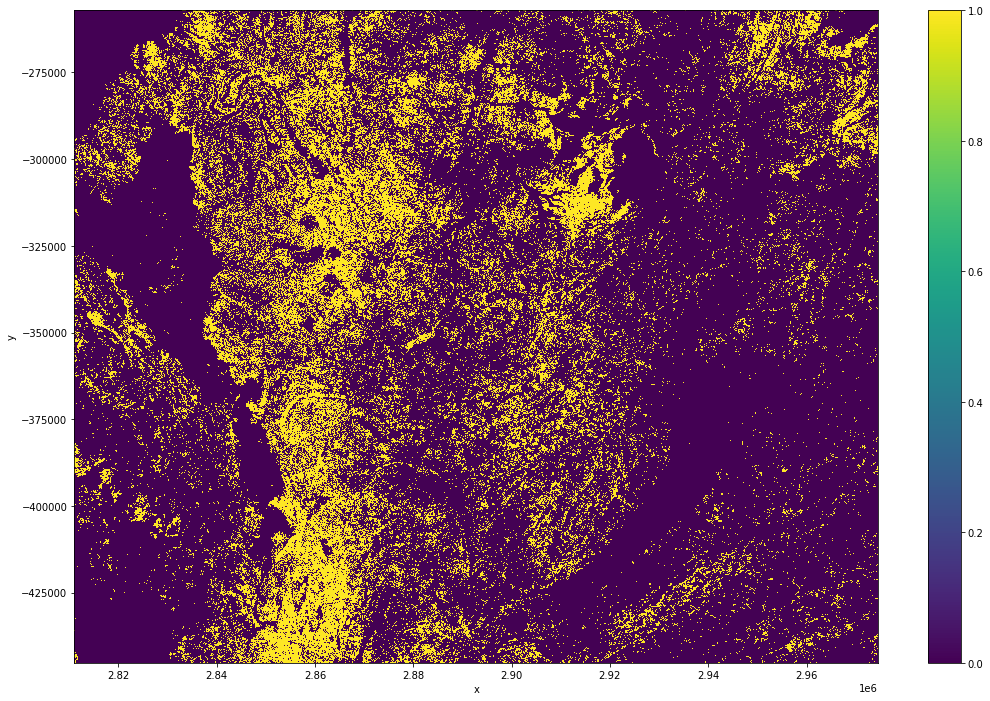

In [6]:
mode.plot(size=12);

## Next steps

To continue working through the notebooks in this `Eastern Africa Cropland Mask` workflow, go to the next notebook `6_Accuracy_assessment.ipynb`.

1. [Extracting_training_data](1_Extracting_training_data.ipynb) 
2. [Inspect_training_data](2_Inspect_training_data.ipynb)
3. [Train_fit_evaluate_classifier](3_Train_fit_evaluate_classifier.ipynb)
4. [Predict](4_Predict.ipynb)
5. **Object-based_filtering (this notebook)**
6. [Accuracy_assessment](6_Accuracy_assessment.ipynb)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Dec 2020


***
***
## RSGISlib shepherd seg parallel, tiled example

### single cpu, tiled

In [ ]:
# from rsgislib.rastergis import populateRATWithMode
# from rsgislib.rastergis import ratutils

# populateRATWithMode(valsimage=results+'Eastern_tile_'+g_id+'_prediction_pixel_'+model_type+'.tif',
#                    clumps=results+'Eastern_tile_'+g_id+'_segmented.kea',
#                    outcolsname ='mode')

# ratutils.populateImageStats(
#               inputImage=results+'Eastern_tile_'+g_id+'_prediction_pixel_'+model_type+'.tif',
#               clumpsFile=results+'Eastern_tile_'+g_id+'_segmented.kea',
#               calcSum=True
# )

In [ ]:
# %time
# #run the segmentation
# with HiddenPrints():
#     tiledsegsingle.performTiledSegmentation(kea_file,
#                                     segmented_kea_file,
#                                     tmpDIR=temp,
#                                     numClusters=60,
#                                     validDataThreshold=validDataTileFraction, 
#                                     tileWidth=width,
#                                     tileHeight=height,
#                                     minPxls=9)

### n cpus, tiled

In [ ]:
# %time
#run the segmentation
# with HiddenPrints():
#     tiledSegParallel.performTiledSegmentation(kea_file,
#                                 segmented_kea_file,
#                                 tmpDIR=temp,
#                                 numClusters=60,
#                                 validDataThreshold=validDataTileFraction, 
#                                 tileWidth=width,
#                                 tileHeight=height,
#                                 minPxls=9,
#                                 ncpus=ncpus)

# # Attribute segments with zonal mean of input image and output as geotiff
# meanImage(tiff_to_segment, segmented_kea_file, segments_zonal_mean, "GTIFF",rsgislib.TYPE_32FLOAT)